<a href="https://www.kaggle.com/code/valerybonneau/ps3e26-final-version?scriptVersionId=193362283" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Table of content
0. [Introduction](#zero)
1. [Import Libraries and Data](#one)
2. [EDA](#two)
4. [Data Preparation](#three)
7. [Ensemble implementation](#seven)
8. [Conclusion and Submission](#eight)

<a id='zero'></a>
**NB: This notebook is a shorter version of [this one](https://www.kaggle.com/code/valerybonneau/ps3e26-eda-automl-nn-and-ensemble). It is meant for submission only.**

# 0. Introduction
## A. Problem Scope
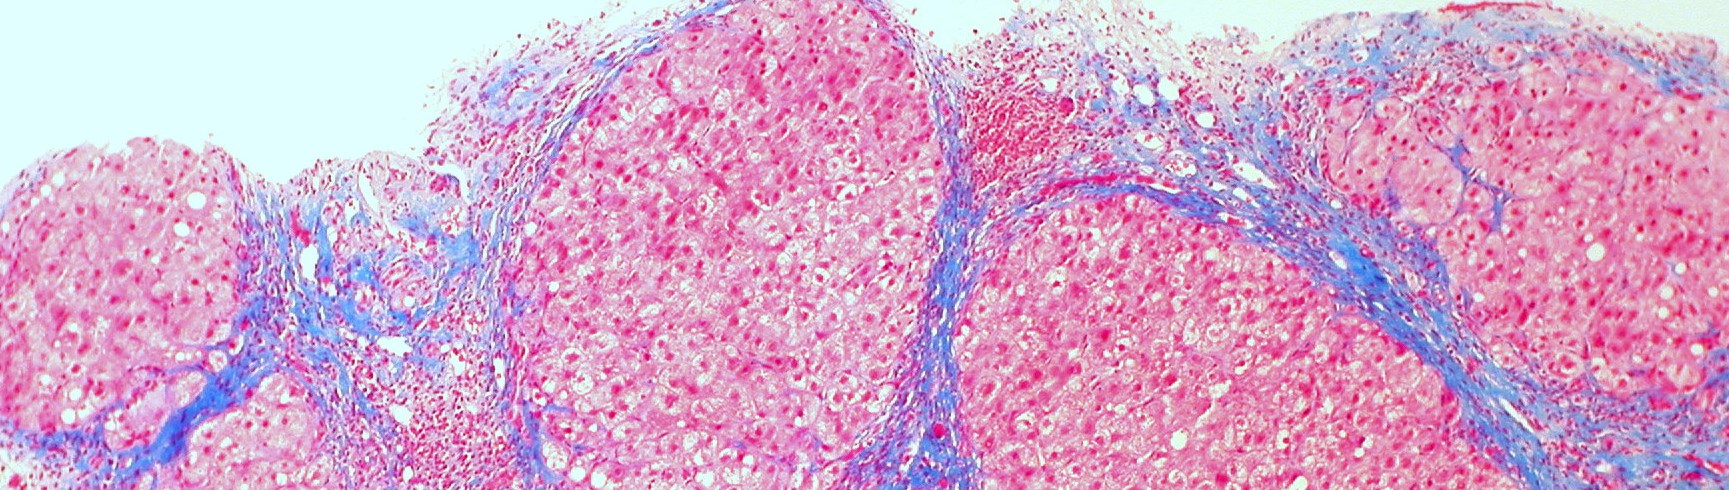
*image taken from [biomedcentral.com](https://blogs.biomedcentral.com/on-medicine/2014/09/22/time-to-reduce-needless-deaths-from-liver-cirrhosis/)*<br><br>
The goal is to predict the outcome of patients with liver desease. More precisely, three outcomes are possible: D = 0 (death), C = 1 (censored), and CL = 2 (censored due to liver transplantation). There are 17 features take from a dataset from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver. The study was conducted between 1974 and 1984.
## B. Personal Goal
I will definitely target the top 15% for this episode. I will focus on the feature engineering rather than the model building (I guess I'll give a try to NN and ensemble). So I will read about Cirrhosis to get a sense of the features impact or how I could create new features.<br>
## C. Acknowledgments
I have been through a lot of notebooks and read or contribute to discussions. Some notebooks or people really did help me a lot (on top of the community). Thanks to [Master Jiraiya](https://www.kaggle.com/arunklenin), [Satya](https://www.kaggle.com/satyaprakashshukl), [Thomas Meißner](https://www.kaggle.com/thomasmeiner) and [Ashish Kumar](https://www.kaggle.com/ashishkumarak). Have a look a their notebooks!



<a id='one'></a>
# 1. Libraries and data import

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import time

# math and stats
import scipy.stats as stats
from scipy.stats import randint, uniform
import tensorflow_probability as tfp

# Preprocessing
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression

# Simple Model
from sklearn.linear_model import LogisticRegression, Ridge, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier

# ensemble models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Neural network model
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

# Env variable (inspired by notebook from https://www.kaggle.com/markuslill)
REPORT = True

sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Set2"))

pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Global Variable
random_seed = 73
epsilon = 1e-7

## Dataset Description
The description of the features and label is available on that [notebook](https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction/data) thanks to [Joakim Arvidsson](https://www.kaggle.com/joebeachcapital).

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2003977%2F4465d9311ccae2f9ccb057fc7e14f26f%2FScreenshot%20from%202023-10-18%2009-42-52.png?generation=1697586187040332&alt=media)

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7905.0,3952.000000,2282.121272,0.00,1976.00,3952.00,5928.00,7904.00
N_Days,7905.0,2030.173308,1094.233744,41.00,1230.00,1831.00,2689.00,4795.00
Age,7905.0,18373.146490,3679.958739,9598.00,15574.00,18713.00,20684.00,28650.00
Bilirubin,7905.0,2.594485,3.812960,0.30,0.70,1.10,3.00,28.00
Cholesterol,7905.0,350.561923,195.379344,120.00,248.00,298.00,390.00,1775.00
Albumin,7905.0,3.548323,0.346171,1.96,3.35,3.58,3.77,4.64
Copper,7905.0,83.902846,75.899266,4.00,39.00,63.00,102.00,588.00
Alk_Phos,7905.0,1816.745250,1903.750657,289.00,834.00,1181.00,1857.00,13862.40
SGOT,7905.0,114.604602,48.790945,26.35,75.95,108.50,137.95,457.25
Tryglicerides,7905.0,115.340164,52.530402,33.00,84.00,104.00,139.00,598.00


In [6]:
print(f'There are {train.isna().sum().sum()} NAs in the train set')
print(f'There are {test.isna().sum().sum()} NAs in the test set')

There are 0 NAs in the train set
There are 0 NAs in the test set


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

<a id='two'></a>
# 2. EDA
After "classical" EDA, I will gain knowledge on Cirrhosis to get some hints or intuition about new features or improve the feature engineering.<br>
But first, EDA. <br>
I will use [ydata profiling](https://docs.profiling.ydata.ai/latest/) at the end but this is just a kind of cross check. You could also use [sweetviz](https://pypi.org/project/sweetviz/)

In [8]:
patients = train.copy().drop(columns=['id'])
features = patients.columns.tolist()
features.pop() # getting rid of the target 'Status'
target = train['Status']

In [9]:
feat_num = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 
            'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
feat_cat = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

`N_Days`, `Age`, `Albumin` and `Platelets` are normally distributed.
`Bilirubin`, `Cholesterol`, `Copper`, `Alk_Phos`, `SGOT`, `Truglycerides` and `Prothrombin` are right skewed


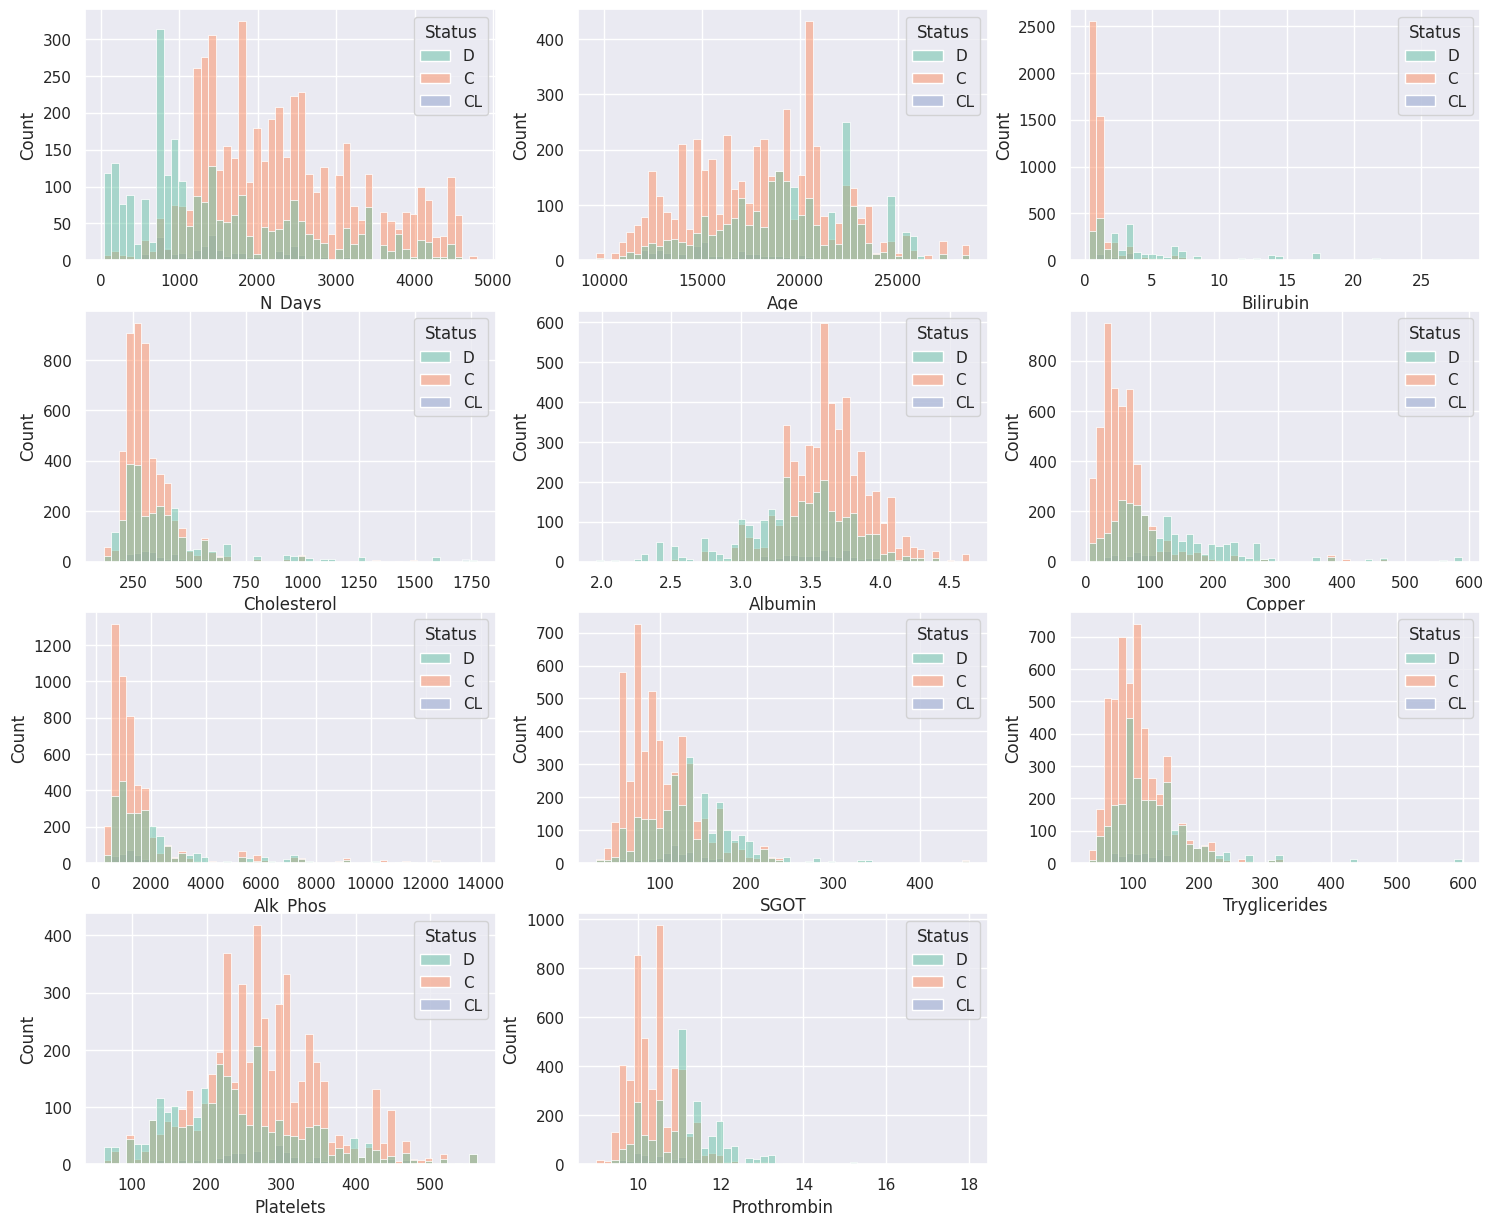

In [10]:
_, axes = plt.subplots(nrows= 4, ncols=3, figsize=(18,15))
for feat, ax in zip(feat_num, axes.ravel()):
    sns.histplot(data=patients, x=feat, bins=50, ax=ax, hue='Status')
axes[-1, -1].set_visible(False)
plt.show()

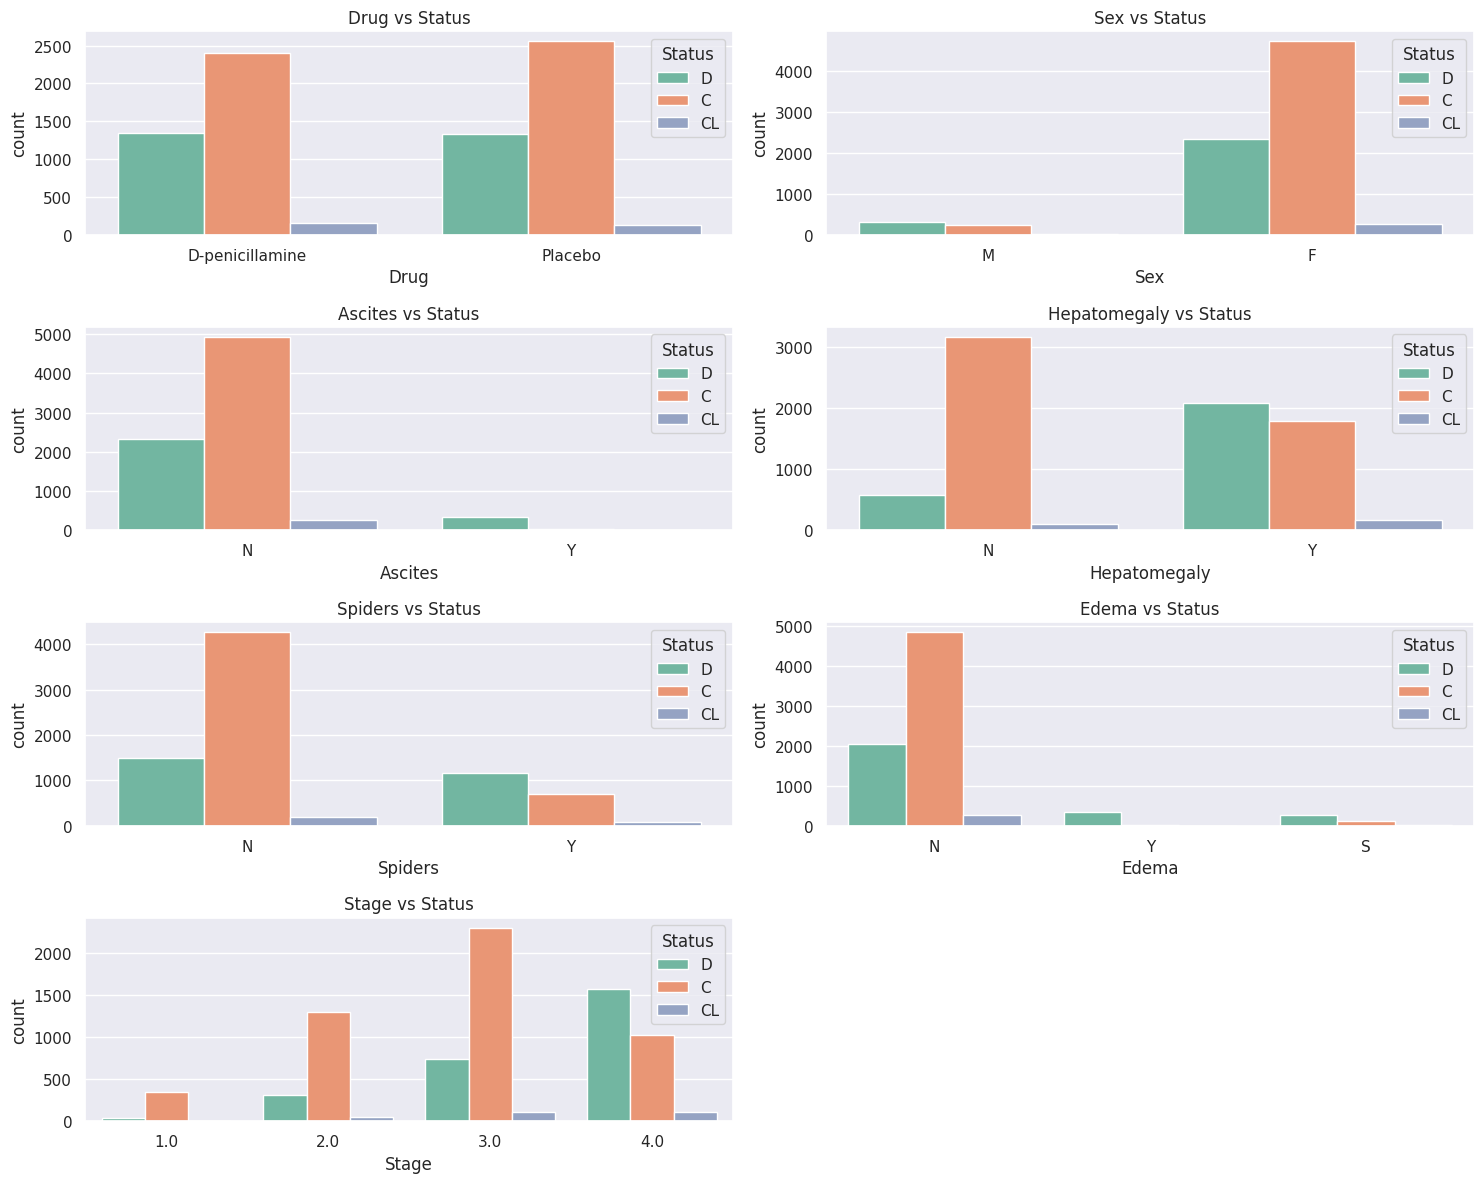

In [11]:
_, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,12))
for feat, ax in zip(feat_cat, axes.ravel()):
    sns.countplot(data=patients, x=feat, ax=ax, hue='Status')
    ax.set_title(f'{feat} vs Status')
axes[-1, -1].set_visible(False)
plt.tight_layout()
plt.show()

## Outliers
`Bilirubin`, `Cholesterol`, `copper`, `Alk_Phos` and `Triglicerides` show a lot of outliers. I've created a function to remove them taking into account the z-score (number of standard deviation to consider when removing the outliers). I'll use it at the data preparation level.

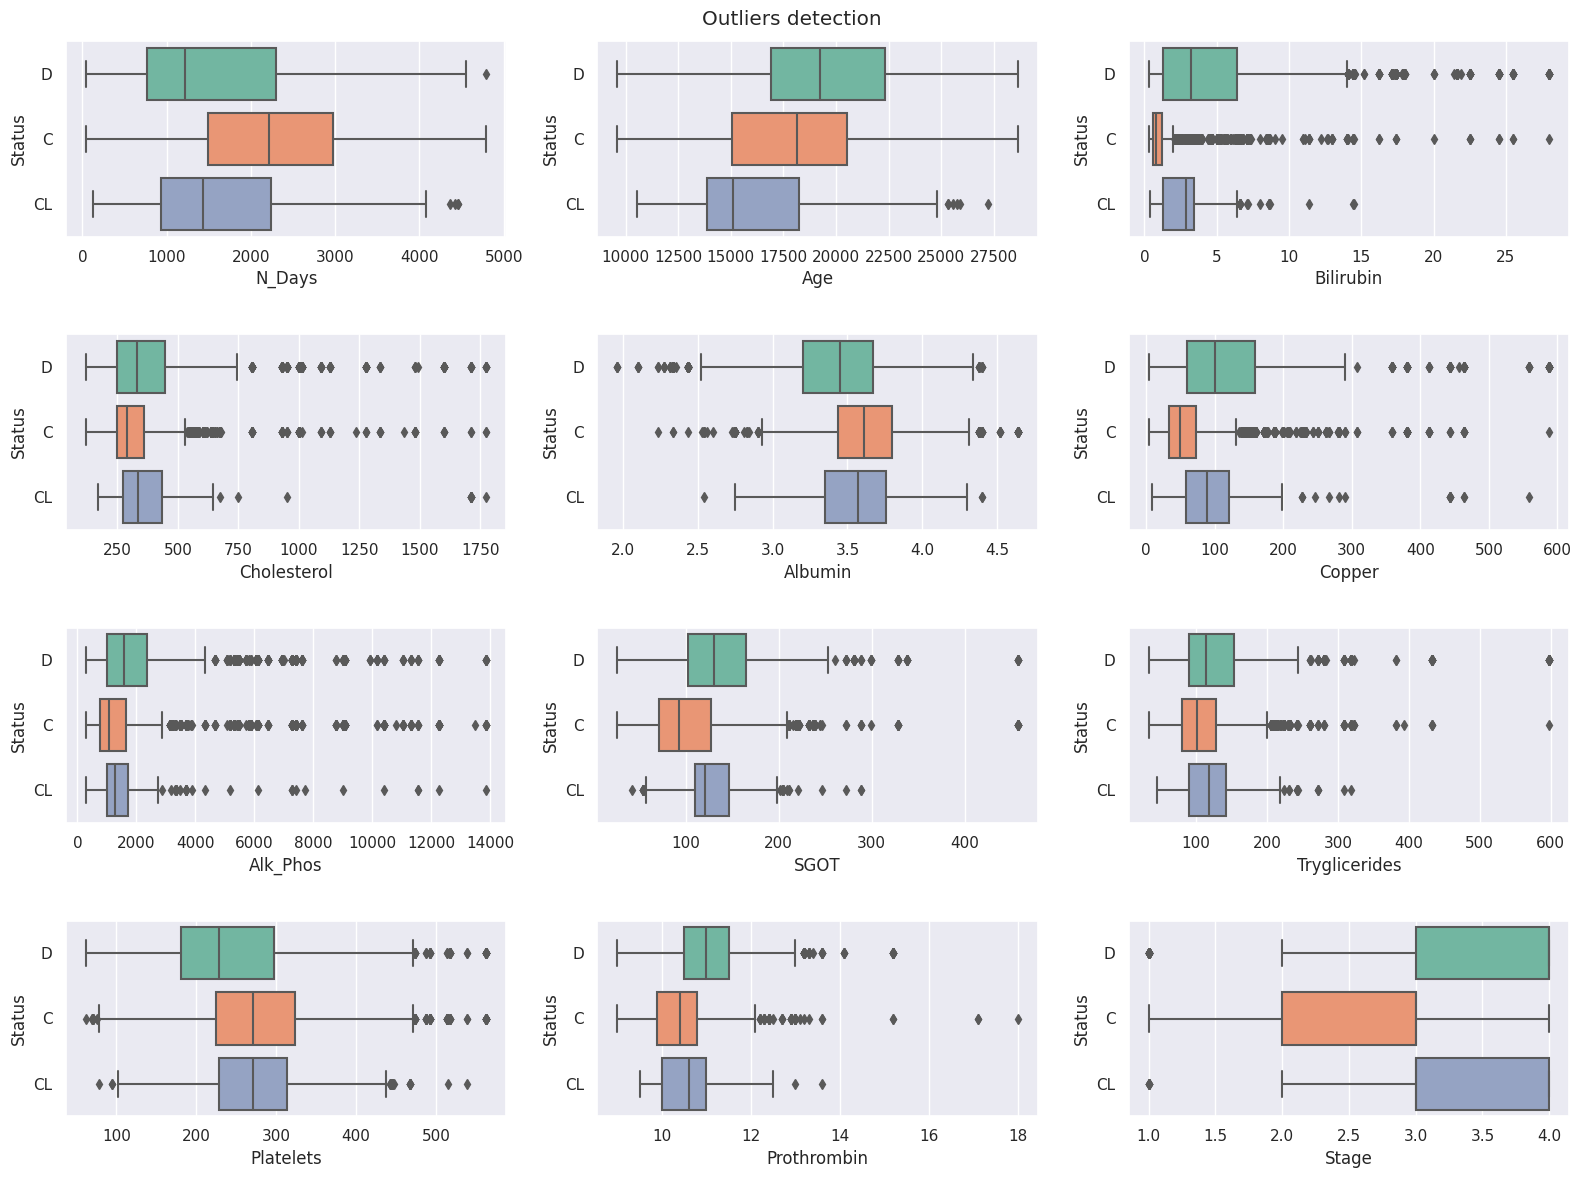

In [12]:
# I keep only the numerical feature for both outliers and heatmap
col_not_object = patients.select_dtypes(exclude='object')

_, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,12))
for feat, ax in zip(col_not_object, axes.ravel()):
    sns.boxplot(data=patients, x=feat, y='Status', ax=ax)
    
plt.suptitle('Outliers detection')
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

## Correlation Matrix
The highest correlation is 0.4 so it seems the features arent very correlated in between.<br>
But I need to change the object features in numeric/categorical values that I can use in the heatmap.

<Axes: >

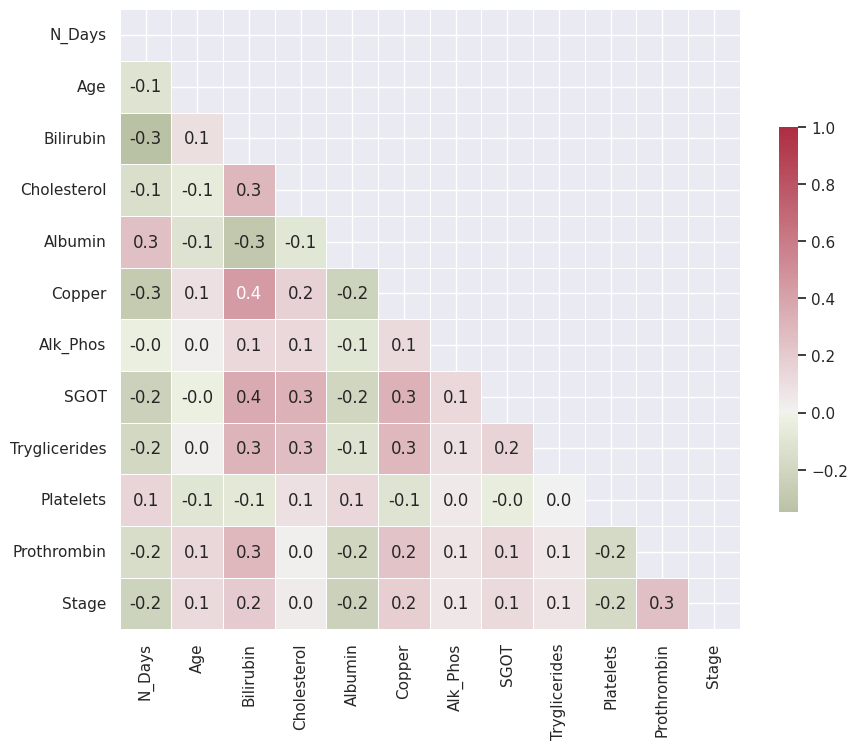

In [13]:
sns.set(rc={'figure.figsize':(10,10)})

col_not_object = patients.select_dtypes(exclude='object')
patients_corr = patients[col_not_object.columns]
corr = patients_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5}, annot=True, fmt='.1f')

In [ ]:
g = sns.pairplot(patients.sample(frac=.2), 
                 hue='Status', 
                 corner=True)

##### Class weight and distribution
The class `CL` is very cleary under represented. I might take the class weight into consideration (though, so far, it never helped. Most probably because the metrics suggested by Kaggle already take that into account)

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=patients, x='Status', order=patients['Status'].value_counts().index)
class_weight = (patients['Status'].value_counts(normalize=True)*100).round(2).tolist()

# adding percentage
for idx, value in enumerate(class_weight):
    plt.text(idx, value+50, f'{value:.2f}%', color='white', ha='center', fontweight='bold')

<a id='four'></a>
# 3. Data Preparation

## Functions for normalization, outliers and scaling

In [ ]:
def normalize_features(X1, X2, left_s, right_s):
    """
    Normalize features from X1 and X2 using the appropriate transformation 
    based on left skewed feature in left_s and right skewed feature in right_s.
    
    Apply fit_transform to X1 and transform to X2 and returns the result
    
    Args:
        X1 (dataframe): dataframe corresponding to X_train
        X2 (dataframe): dataframe corresponding to X_test
        left_s: a list of left skewed features
        right_s: a list of right skewed features
        
    Returns:
        X1, X2: the dataframes after normalization of their features
    """
    X1 = X1.copy()
    X2 = X2.copy()
    try:
        for feat in left_s:
            X1[feat] = np.sqrt(X1[feat])
            X2[feat] = np.sqrt(X2[feat])
    except:
        pass    
    try:
        for feat in right_s:
            X1[feat] = np.log1p(X1[feat])
            X2[feat] = np.log1p(X2[feat])
    except:
        pass
    # changing the type Sparse[float64, 0] to float64
    for feat in X1.columns:
        if pd.api.types.is_sparse(X1[feat].dtype):
            X1[feat] = X1[feat].astype(float)
            X2[feat] = X2[feat].astype(float)
    
    return X1, X2

In [ ]:
def remove_outliers(X, y, times_z=5):
    """
    Remove the outliers from a DataFrame X and the equivalent indexes from a DataFrame y.
    
    Args:
        X (dataframe): The dataframe to remove outliers from
        y (dataframe): The dataframe used for training the model and in which rows indexes of X are removed
        times_z (int): Z-score threshold. If times_z is 3, the values that are bigger than 3*z or smaller than -3*z will be removed
        
    Returns:
        X_o, y_o: The dataframes without the outliers
    """
    z = np.abs(stats.zscore(X))
    outlier_mask = (z < times_z).all(axis=1)
    X_outliers = X[outlier_mask]
    y_outliers = y[outlier_mask]
    return X_outliers, y_outliers

In [ ]:
def scale_features(X1, X2=pd.DataFrame()):
    X1 = X1.copy()
    X2 = X2.copy()
    
    cols = X1.columns
    scaler= MinMaxScaler()
    X1 = scaler.fit_transform(X1)
    X2 = scaler.transform(X2)

    X1 = pd.DataFrame(data=X1, columns=cols)
    X2 = pd.DataFrame(data=X2, columns=cols)
    
    return X1, X2

## Data processing

In [26]:
X_train = train.copy().drop(columns=['id', 'Status'])
y_train = train['Status'].copy()
X_test = test.copy().drop(columns=['id'])

Going through that [notebook](https://www.kaggle.com/code/markuslill/s3e26-feature-engineering-model-comparison/notebook) and that [one](https://www.kaggle.com/code/satyaprakashshukl/multi-class-prediction-of-cirrhosis-outcomes/notebook), I decided to change the way I was preocessing the data.

In [27]:
cat_feat = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders']
ordinal_feat = ['Stage', 'Edema', 'Drug' ]
numerical_feat = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

right_skewed = ['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Truglycerides', 'Prothrombin']
left_skewed = []

In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=True)
train_cat = ohe.fit_transform(X_train[cat_feat])
X_train_cat = pd.DataFrame.sparse.from_spmatrix(train_cat, columns=ohe.get_feature_names_out(cat_feat))

test_cat = ohe.transform(X_test[cat_feat])
X_test_cat = pd.DataFrame.sparse.from_spmatrix(test_cat, columns=ohe.get_feature_names_out(cat_feat))


from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_ord = oe.fit_transform(X_train[ordinal_feat])
X_train_ord = pd.DataFrame(train_ord, columns=oe.get_feature_names_out(ordinal_feat))
test_ord = oe.transform(X_test[ordinal_feat])
X_test_ord = pd.DataFrame(test_ord, columns=oe.get_feature_names_out(ordinal_feat))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [29]:
X_train = pd.concat([X_train[numerical_feat], X_train_ord, X_train_cat], axis=1)
X_test = pd.concat([X_test[numerical_feat], X_test_ord, X_test_cat], axis=1)

y_train = pd.DataFrame(y_train).squeeze()

In [30]:
# Adapted from https://www.kaggle.com/code/markuslill/s3e26-xgbclassifer

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin

class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    # Placeholder concept, assuming 'Bilirubin' improvement is a measure of effectiveness
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    # From data set explanations above let's add all the "bad" symptoms
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        symptom_columns = ['Ascites_Y', 'Hepatomegaly_Y', 'Spiders_Y', 'Edema']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites_Y', 'Hepatomegaly_Y', 'Spiders_Y', 'Edema']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])

        # Drop the original symptom columns and add the new encoded features
        # X_transformed.drop(columns=self.symptom_columns, inplace=True)
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
    #('scaling', ScalingTransformer()),
    # ... ?
])

# Apply the pipeline to your dataframes
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [31]:
X_train_o, y_train_o = remove_outliers(X_train, y_train, 6)

In [32]:
X_train_o['Age'] = X_train_o['Age']/365.25
X_test['Age'] = X_test['Age']/365.25

X_train_o['N_Days'] = X_train_o['N_Days']/365.25
X_test['N_Days'] = X_test['N_Days']/365.25

/tmp/ipykernel_47/3342701072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_o['Age'] = X_train_o['Age']/365.25
/tmp/ipykernel_47/3342701072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_o['N_Days'] = X_train_o['N_Days']/365.25


In [33]:
X_train_o.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema,Drug,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_0.00.00.00.0,Symptom_Score_0.00.00.01.0,Symptom_Score_0.00.00.02.0,Symptom_Score_0.00.01.00.0,Symptom_Score_0.00.01.01.0,Symptom_Score_0.00.01.02.0,Symptom_Score_0.01.00.00.0,Symptom_Score_0.01.00.01.0,Symptom_Score_0.01.00.02.0,Symptom_Score_0.01.01.00.0,Symptom_Score_0.01.01.01.0,Symptom_Score_0.01.01.02.0,Symptom_Score_1.00.00.00.0,Symptom_Score_1.00.00.01.0,Symptom_Score_1.00.00.02.0,Symptom_Score_1.00.01.00.0,Symptom_Score_1.00.01.01.0,Symptom_Score_1.00.01.02.0,Symptom_Score_1.01.00.00.0,Symptom_Score_1.01.00.01.0,Symptom_Score_1.01.00.02.0,Symptom_Score_1.01.01.00.0,Symptom_Score_1.01.01.01.0,Symptom_Score_1.01.01.02.0,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
0,2.735113,58.951403,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,2.0,0.0,0.0,1.0,0.0,0.0,0.0,20533,59,2,7.705,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446.6125,-1595.35,2,8
1,7.047228,52.668036,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,16663,53,2,3.186,0.9,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,394.8225,-1435.56,7,0
3,7.052704,50.540726,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,2.0,0.0,1.0,0.0,0.0,0.0,0.0,15884,51,2,2.100,0.6,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,432.1000,-1648.90,7,0
4,2.157426,45.607118,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,3.0,0.0,1.0,0.0,0.0,1.0,0.0,15870,46,1,4.015,1.1,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,327.8250,-1176.25,2,1
5,1.924709,52.758385,0.6,227.0,3.46,34.0,6456.2,60.63,68.0,213.0,11.5,2.0,0.0,0.0,0.0,0.0,1.0,0.0,18567,53,2,2.076,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1630.2225,-6452.14,1,11


<a id='five'></a>
# 5. Models Training
This will take forever but you will get best parameters for each model and the score attached. You can increase the number of iterations to make sure you have the best parameters. I asked ChatGPT for the set of parameters but it needs to be checked. Some parameters are pretty useless, while sometimes ChatGPT forgets some important ones.

## Cross Validation Strategy

In [34]:
from sklearn.metrics import log_loss
# adapted from https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense
# Thanks a lot to AmbrosM (https://www.kaggle.com/ambrosm)

def cross_val(model, X, y):
    tic = time.time()
       
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
    
    logloss = []
    logloss_tr = []

    for fold, (indX_tr, indX_va) in enumerate(kf.split(X, y)):
        X_tr = X.iloc[indX_tr]
        X_va = X.iloc[indX_va]
        y_tr = y.iloc[indX_tr]
        y_va = y.iloc[indX_va]
        
        X_tr, X_va = scale_features(X_tr, X_va)

        model.fit(X_tr, y_tr)
        y_va_pred = model.predict_proba(X_va)
        y_tr_pred = model.predict_proba(X_tr)

        logloss.append(log_loss(y_va, y_va_pred, labels=[0, 1, 2]))
        logloss_tr.append(log_loss(y_tr, y_tr_pred, labels=[0, 1, 2]))
        
    logloss = np.array(logloss).mean()
    logloss_tr = np.array(logloss_tr).mean()
    
    tac= time.time()
    print(f'training score: {logloss_tr}')
    print(f'execution time of {model}: {round((tac-tic),2)} seconds')
    return logloss_tr, logloss, model

<a id='seven'></a>
# 7. Ensemble with best models
I'm keeping 6 models for now but they are all trees related models. I'll add the NN as soon as I'm happy with the resutls.

In [35]:
params_gbc = {'loss':'log_loss', 'learning_rate':0.1, 'max_depth':3,
              'min_samples_leaf':4, 'min_samples_split':2, 'n_estimators':300, 
              'subsample':0.8, 'random_state':60}
gbc = GradientBoostingClassifier(**params_gbc)

params_xgbc = {'n_estimators': 567, 'learning_rate': 0.03820381248841593, 'max_depth': 9, 
                        'subsample': 0.5717706003972762, 'colsample_bytree': 0.1386492762520236, 'min_child_weight': 6}


# params_xgbc = {
#     'objective': 'multi_logloss', 
#     'max_depth': 6, 
#     'learning_rate': 0.010009541152584345, 
#     'n_estimators': 1878,
#     'min_child_weight': 9, 
#     'colsample_bytree': 0.3292032860985591, 
#     'reg_alpha': 0.10626128775335533, 
#     'reg_lambda': 0.624196407787772, 
#     'random_state': 42,
#     'tree_method': 'hist', 
#     'eval_metric': 'mlogloss',
#     'subsample': 0.47524425009347593
# }
xgbc = XGBClassifier(**params_xgbc)

params_lgbmc = { 'objective': 'multi_logloss', 
                'max_depth': 9, 
                'min_child_samples': 14, 
                'learning_rate': 0.034869481921747415, 
                'n_estimators': 274, 
                'min_child_weight': 9, 
                'colsample_bytree': 0.1702910221565107, 
                'reg_alpha': 0.10626128775335533, 
                'reg_lambda': 0.624196407787772, 
                'random_state': random_seed}

lgbmc = LGBMClassifier(**params_lgbmc)

params_hgbc = {'min_samples_leaf': 22, 'max_leaf_nodes': 4, 'max_iter': 443,
              'max_depth': 20, 'learning_rate': 0.05, 'l2_regularization': 0.1}
hgbc = HistGradientBoostingClassifier(**params_hgbc)

params_sgdc = {'penalty': 'elasticnet', 'max_iter': 200, 'loss': 'log_loss', 'learning_rate': 'adaptive',
   'eta0': 1.0, 'early_stopping': True, 'alpha': 0.01}
sgdc = SGDClassifier(**params_sgdc)

In [36]:
X_train_o_scaled, X_test_scaled = scale_features(X_train_o, X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [40]:
# Ensemble model
# if all values <.4 then choose min
# if fall values >0.6 choose max

def compute_result(row):
    if row.min() < 0.40 and row.max() > 0.60:
        return np.mean(row)
    elif row.min() < 0.40:
        return row.min()
    else:
        return row.max()
    

xgbc.fit(X_train_o_scaled, y_train_o)
lgbmc.fit(X_train_o_scaled, y_train_o)
    
pred1 = xgbc.predict_proba(X_test_scaled)
pred2 = lgbmc.predict_proba(X_test_scaled)

pred1 = pd.DataFrame(pred1)
pred2 = pd.DataFrame(pred2)
# Apply the function row-wise across the three Series
predictions = pd.concat([pred1, pred2]).groupby(level=0, axis=0).apply(lambda x: x.apply(compute_result, axis=0))


<a id='eight'></a>
# Conclusion and Submission

In [44]:
# predictions = predictions.reset_index(drop=True)

submission = pd.DataFrame({
    'id': test['id'].astype(int),
    'Status_C': predictions.iloc[:, 0],
    'Status_CL': predictions.iloc[:, 1],
    'Status_D': predictions.iloc[:, 2]
})

submission.to_csv('submission.csv', index=False)